## Inequality & Poverty

In [1]:
# Import necessary libraries
import pandas as pd

# Load the data files
income_data_path = 'income_data.csv'
health_expectancy_data_path = 'health_expectancy_data.csv'

# Read the income and health expectancy data
income_data = pd.read_csv(income_data_path)
health_expectancy_data = pd.read_csv(health_expectancy_data_path)

# Step 1: Standardise column names and filter relevant columns
# Strip trailing spaces from column names in both datasets
income_data.columns = income_data.columns.str.strip()
health_expectancy_data.columns = health_expectancy_data.columns.str.strip()

# Rename relevant columns for income data
income_data = income_data.rename(columns={
    'Local Authority District code (2019)': 'Area Code',
    'Local Authority District name (2019)': 'Area Name',
    'Income - Average score': 'Income Score'
})

# Select only necessary columns from income data
income_data_cleaned = income_data[['Area Code', 'Area Name', 'Income Score']]

# Filter relevant columns from health expectancy data
health_expectancy_data_cleaned = health_expectancy_data[
    ['Area Code', 'Area Name', 'Sex', 'Value']
]

# Step 2: Pivot health expectancy data to get male and female stats side by side
health_pivot = health_expectancy_data_cleaned.pivot_table(
    index=['Area Code', 'Area Name'],
    columns='Sex',
    values='Value',
    aggfunc='mean'
).reset_index()

# Step 3: Average male and female life expectancy
health_pivot['Average Life Expectancy'] = health_pivot[['Male', 'Female']].mean(axis=1)

# Step 4: Merge income data and averaged life expectancy data
merged_data = pd.merge(income_data_cleaned, health_pivot, on=['Area Code', 'Area Name'], how='inner')

# Step 5: Handle missing values (drop rows with any missing values for now)
merged_data_cleaned = merged_data.dropna()
print(merged_data_cleaned)


     Area Code             Area Name  Income Score  Female   Male  \
0    E06000001            Hartlepool         0.228   57.39  57.03   
1    E06000002         Middlesbrough         0.251   58.52  58.53   
2    E06000003  Redcar and Cleveland         0.186   60.34  60.23   
3    E06000004      Stockton-on-Tees         0.164   56.84  57.79   
4    E06000005            Darlington         0.153   62.16  58.09   
..         ...                   ...           ...     ...    ...   
115  E09000029                Sutton         0.095   65.55  67.29   
116  E09000030         Tower Hamlets         0.192   59.35  62.62   
117  E09000031        Waltham Forest         0.152   69.71  64.01   
118  E09000032            Wandsworth         0.107   68.08  62.73   
119  E09000033           Westminster         0.135   64.44  65.71   

     Average Life Expectancy  
0                     57.210  
1                     58.525  
2                     60.285  
3                     57.315  
4               

C:\Users\raath\AppData\Local\Temp\ipykernel_79320\1686340207.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave room for the colorbar


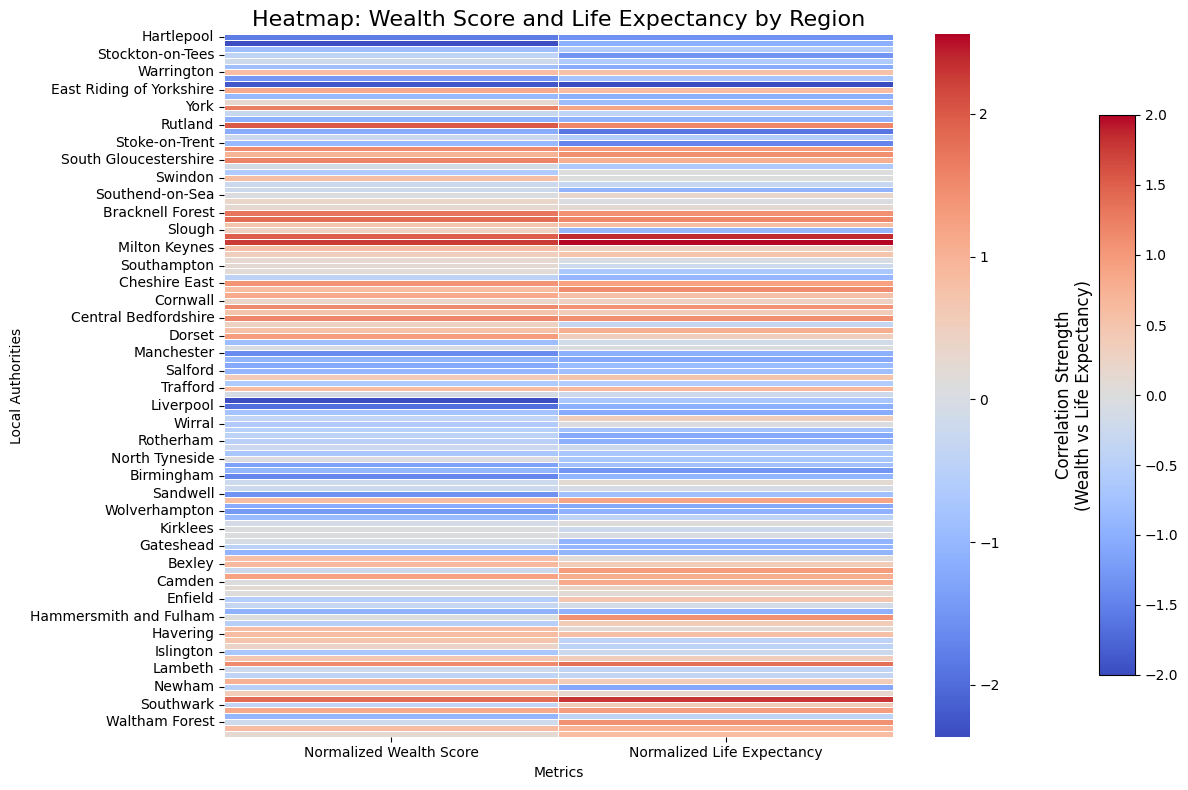

In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase


# Invert the Income Score so that higher values represent wealthier regions
merged_data_cleaned['Inverted Income Score'] = -merged_data_cleaned['Income Score']

# Normalise the data with the inverted score
scaler = StandardScaler()
normalized_data = scaler.fit_transform(
    merged_data_cleaned[['Inverted Income Score', 'Average Life Expectancy']]
)

# Convert normalised data back to a DataFrame
normalized_df = pd.DataFrame(
    normalized_data,
    columns=['Normalized Wealth Score', 'Normalized Life Expectancy'],
    index=merged_data_cleaned['Area Name']
)

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(normalized_df, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Customize the heatmap title and labels
plt.title('Heatmap: Wealth Score and Life Expectancy by Region', fontsize=16)
plt.xlabel('Metrics')
plt.ylabel('Local Authorities')

# Add a legend/key to explain the color gradient
cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.03, 0.7])  # Position the colorbar
norm = Normalize(vmin=-2, vmax=2)  # Adjust vmin and vmax to reflect normalized range
ColorbarBase(cbar_ax, cmap='coolwarm', norm=norm, orientation='vertical')

# Add labels to the colorbar for clarity
cbar_ax.set_ylabel('Correlation Strength\n(Wealth vs Life Expectancy)', fontsize=12)
cbar_ax.yaxis.set_label_position('left')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave room for the colorbar

plt.savefig("heatmap.jpeg", format="jpeg", dpi=300, bbox_inches="tight")
# Display the updated heatmap
plt.show()



C:\Users\raath\PycharmProjects\MachineLearningProject\HDRC_Project\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


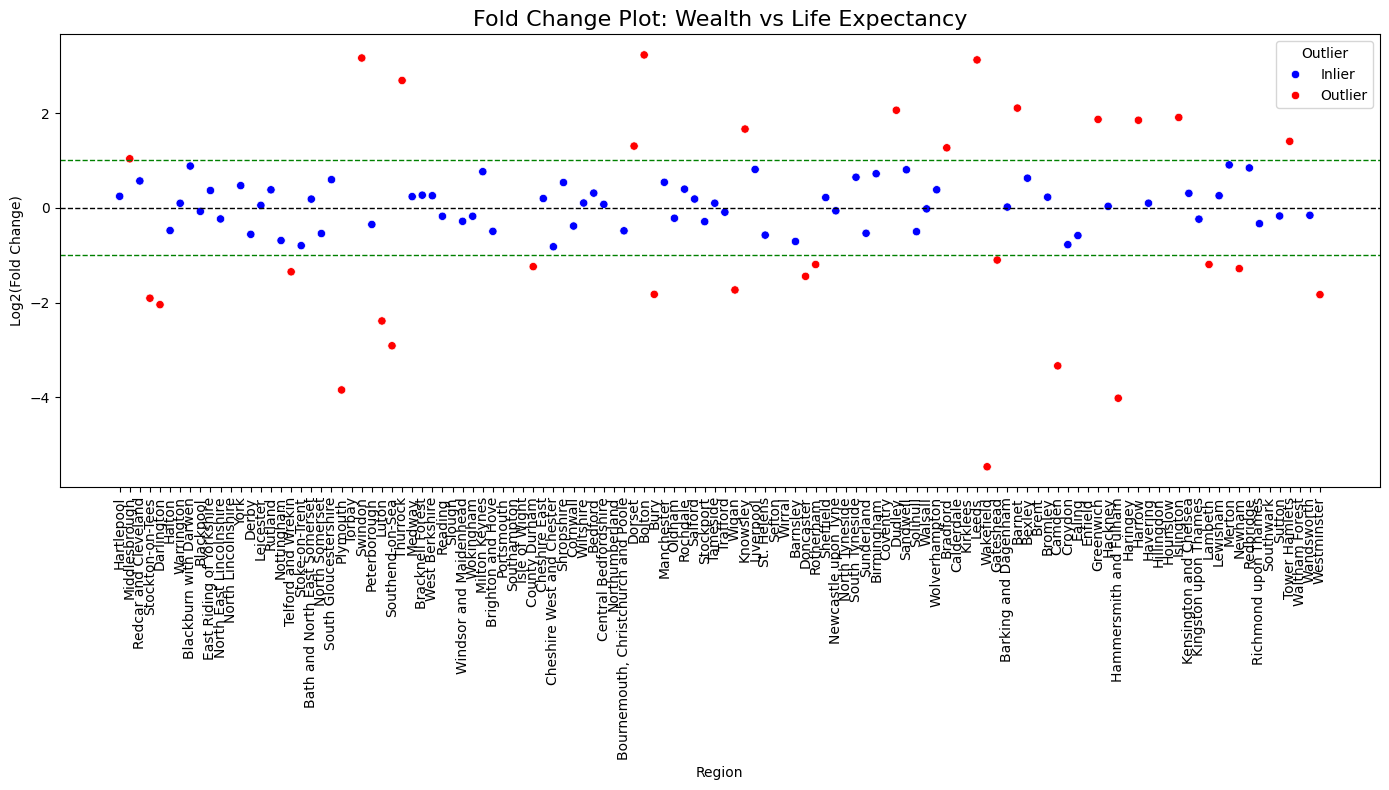

In [20]:
import numpy as np

# Step 1: Calculate Fold Change
# Ratio of normalised wealth score to normalised life expectancy
normalized_df['Fold Change'] = np.log2(normalized_df['Normalized Wealth Score'] / normalized_df['Normalized Life Expectancy'])

# Step 2: Define thresholds for outliers
threshold = 1  # Example threshold: Fold Change > 1 or < -1
normalized_df['Outlier'] = np.where(np.abs(normalized_df['Fold Change']) > threshold, 'Outlier', 'Inlier')

# Step 3: Plot the Fold Change
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    x=normalized_df.index,
    y=normalized_df['Fold Change'],
    hue=normalized_df['Outlier'],
    palette={'Outlier': 'red', 'Inlier': 'blue'},
    legend='full'
)

# Customize the plot
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Baseline at 0
plt.axhline(y=threshold, color='green', linestyle='--', linewidth=1)  # Positive threshold
plt.axhline(y=-threshold, color='green', linestyle='--', linewidth=1)  # Negative threshold
plt.title('Fold Change Plot: Wealth vs Life Expectancy', fontsize=16)
plt.xlabel('Region')
plt.ylabel('Log2(Fold Change)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()


# Display the plot
plt.show()


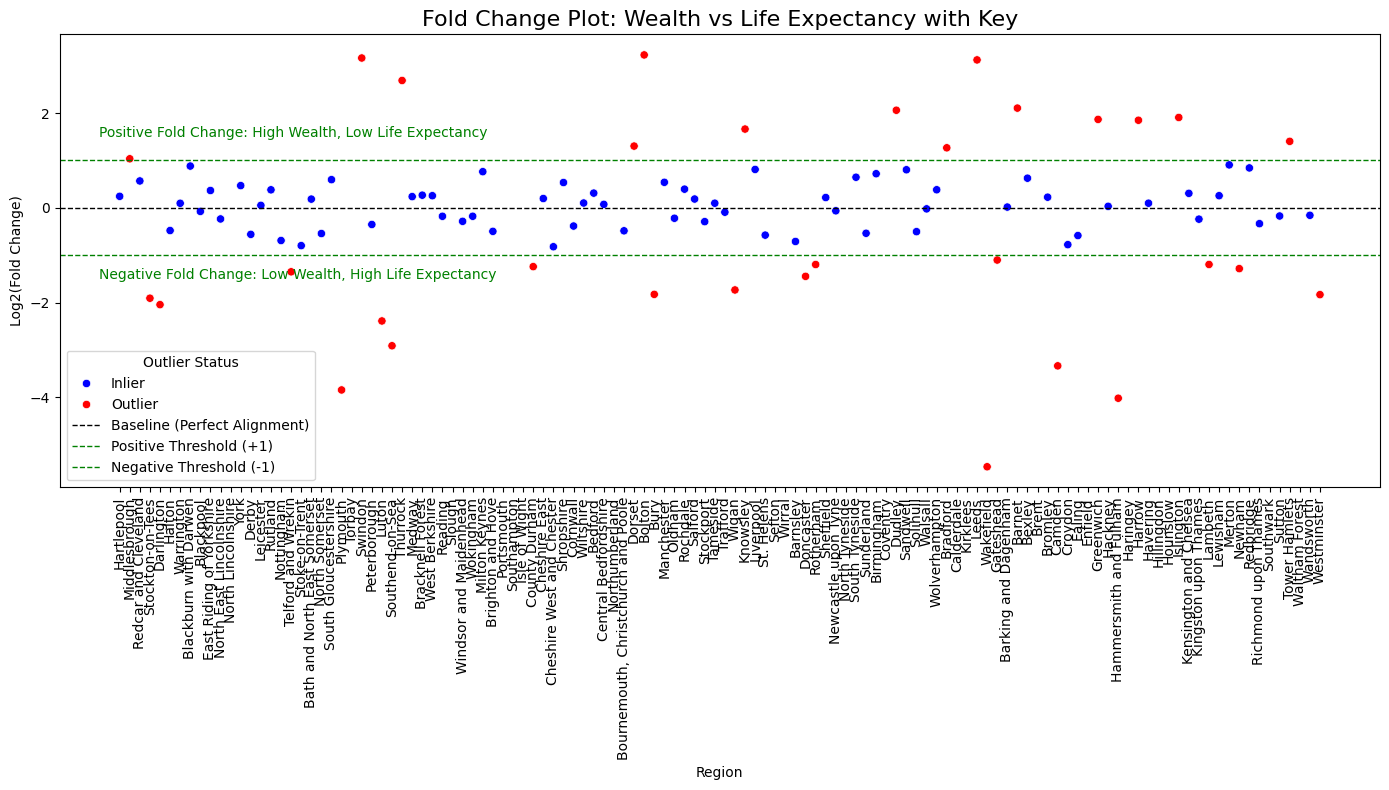

In [21]:
# Plot the Fold Change again with a key to explain the fold change
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    x=normalized_df.index,
    y=normalized_df['Fold Change'],
    hue=normalized_df['Outlier'],
    palette={'Outlier': 'red', 'Inlier': 'blue'},
    legend='full'
)

# Add horizontal lines for thresholds
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label="Baseline (Perfect Alignment)")
plt.axhline(y=threshold, color='green', linestyle='--', linewidth=1, label="Positive Threshold (+1)")
plt.axhline(y=-threshold, color='green', linestyle='--', linewidth=1, label="Negative Threshold (-1)")

# Add key explanation
plt.text(-2, 1.5, "Positive Fold Change: High Wealth, Low Life Expectancy", fontsize=10, color='green')
plt.text(-2, -1.5, "Negative Fold Change: Low Wealth, High Life Expectancy", fontsize=10, color='green')

# Customize the plot
plt.title('Fold Change Plot: Wealth vs Life Expectancy with Key', fontsize=16)
plt.xlabel('Region')
plt.ylabel('Log2(Fold Change)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.legend(title="Outlier Status")
plt.tight_layout()

plt.savefig("fold_change_plot.jpeg", format="jpeg", dpi=300, bbox_inches="tight")

# Display the updated plot
plt.show()


In [10]:
# Calculate Pearson Correlation Coefficient
correlation = merged_data_cleaned['Inverted Income Score'].corr(
    merged_data_cleaned['Average Life Expectancy']
)

# Compute R² (coefficient of determination)
r_squared = correlation ** 2

print(f"Pearson Correlation Coefficient (r): {correlation:.2f}")
print(f"Coefficient of Determination (R²): {r_squared:.2f}")


Pearson Correlation Coefficient (r): 0.82
Coefficient of Determination (R²): 0.68


In [25]:
import numpy as np
import pandas as pd

# Re-add Area Name to the normalized dataset
normalized_df = pd.DataFrame(
    normalized_data,
    columns=['Normalized Wealth Score', 'Normalized Life Expectancy'],
    index=merged_data_cleaned.index
)

# Add Area Name back to the normalized dataset
normalized_df['Area Name'] = merged_data_cleaned['Area Name']

# Step 1: Recalculate Fold Change
normalized_df['Fold Change'] = np.log2(
    normalized_df['Normalized Wealth Score'] / normalized_df['Normalized Life Expectancy']
)

# Step 2: Identify Outliers
threshold = 1  # Define outlier threshold
normalized_df['Outlier'] = np.where(
    np.abs(normalized_df['Fold Change']) > threshold, 'Outlier', 'Inlier'
)

# Step 3: Identify Top 10 Outlier Regions
top_outliers = normalized_df.loc[normalized_df['Outlier'] == 'Outlier'].copy()
top_outliers['Absolute Fold Change'] = top_outliers['Fold Change'].abs()
top_10_outliers = top_outliers.nlargest(10, 'Absolute Fold Change')

# Step 4: Add Descriptions
top_10_outliers['Description'] = top_10_outliers['Fold Change'].apply(
    lambda x: "Lower Wealth, Higher Life Expectancy" if x < 0 else "High Wealth, Low Life Expectancy"
)

# Step 5: Prepare Table
top_10_outliers_table = top_10_outliers[['Area Name', 'Fold Change', 'Description']].reset_index(drop=True)

print(top_10_outliers_table)




                Area Name  Fold Change                           Description
0               Wakefield    -5.467991  Lower Wealth, Higher Life Expectancy
1  Hammersmith and Fulham    -4.020722  Lower Wealth, Higher Life Expectancy
2                Plymouth    -3.846219  Lower Wealth, Higher Life Expectancy
3                  Camden    -3.337210  Lower Wealth, Higher Life Expectancy
4                  Bolton     3.228660      High Wealth, Low Life Expectancy
5                 Swindon     3.163708      High Wealth, Low Life Expectancy
6                   Leeds     3.123320      High Wealth, Low Life Expectancy
7         Southend-on-Sea    -2.912898  Lower Wealth, Higher Life Expectancy
8                Thurrock     2.688922      High Wealth, Low Life Expectancy
9                   Luton    -2.389284  Lower Wealth, Higher Life Expectancy


C:\Users\raath\PycharmProjects\MachineLearningProject\HDRC_Project\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


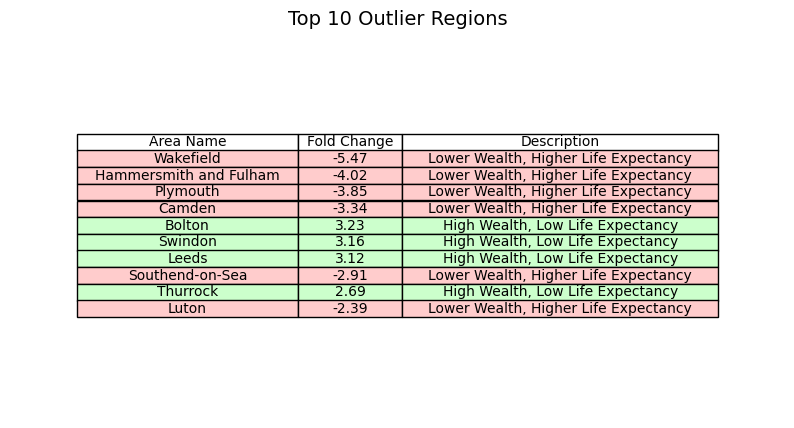

In [28]:
import matplotlib.pyplot as plt

# Round the Fold Change values to 2 decimal places
top_10_outliers_table['Fold Change'] = top_10_outliers_table['Fold Change'].round(2)

# Create a figure for the table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')  # Turn off the axis

# Create the table
table_data = top_10_outliers_table.values.tolist()
columns = top_10_outliers_table.columns.tolist()

# Add the table to the plot
table = ax.table(
    cellText=table_data,
    colLabels=columns,
    cellLoc='center',
    loc='center',
    colLoc='center'
)

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))

# Highlight specific rows based on the description
for row_index, row in enumerate(table_data, start=1):
    description = row[-1]  # The last column contains the description
    color = "#FFCCCC" if "Lower Wealth" in description else "#CCFFCC"
    for col_index in range(len(columns)):
        table[(row_index, col_index)].set_facecolor(color)

# Set title
plt.title("Top 10 Outlier Regions", fontsize=14)

top_10_outliers_table = top_10_outliers[['Area Name', 'Fold Change', 'Description']].reset_index(drop=True)
plt.savefig("outliers.jpeg", format="jpeg", dpi=300, bbox_inches="tight")

# Show the table
plt.show()

